# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Описание данных

**Признаки**
* `DateCrawled` — дата скачивания анкеты из базы
* `VehicleType` — тип автомобильного кузова
* `RegistrationYear` — год регистрации автомобиля
* `Gearbox` — тип коробки передач
* `Power` — мощность (л. с.)
* `Model` — модель автомобиля
* `Kilometer` — пробег (км)
* `RegistrationMonth` — месяц регистрации автомобиля
* `FuelType` — тип топлива
* `Brand` — марка автомобиля
* `Repaired` — была машина в ремонте или нет
* `DateCreated` — дата создания анкеты
* `NumberOfPictures` — количество фотографий автомобиля
* `PostalCode` — почтовый индекс владельца анкеты (пользователя)
* `LastSeen` — дата последней активности пользователя

**Целевой признак**
* Price — цена (евро)

## Подготовка данных

In [2]:
#pip install shap

In [3]:
#pip install catboost

### Установка библиотек и настройка окружения

In [14]:
import pandas as pd 
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
import warnings
import shap

from IPython.display import display

from sklearn.metrics import make_scorer, f1_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier

from catboost import CatBoostClassifier

import scipy
import scipy.stats as stats
from scipy.stats import poisson

import phik
from phik import resources, report

warnings.filterwarnings('ignore')

In [5]:
pd.set_option('display.min_rows', 20)
pd.set_option('display.max_rows', 20)
pd.options.display.float_format = '{:,.2f}'.format

### Инициализация полезных функций

In [6]:
# функция информации по таблице
def dataframe_summary(df, string):
    # Вывод общей информации
    print("Общая информация по таблице:", string)
    df.info()

    # Вывод статистического описания
    print("\n Статистическое описание:")
    display(df.describe().transpose())

    # Вывод случайных примеров
    print("\nСлучайные примеры:")
    display(df.sample(5))

    # Вывод количества строк и столбцов
    print("\nКоличество строк и столбцов:", df.shape)
    
    # Вывод количества явных дубликатов
    print("\nКоличество явных дубликатов:", df.duplicated().sum())
    print('')

In [7]:
# функция поиска пропусков
def analyze_missing_values(df, string):
        total = df.isnull().sum().sort_values(ascending=False)
        percent = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending=False)
        missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
        missing_data = missing_data.query('Total > 0')

        # Вывод информации о пропусках
        print(f"Пропуски в датафрейме {string}:\n{missing_data}\n")

        # Создание и отображение тепловой карты
        plt.figure(figsize=(12, 8))
        sns.heatmap(df.isnull(), cbar=False, yticklabels=False)
        plt.title(f"Heatmap пропусков для {string}")
        plt.show()

In [ ]:
# Функция для преобразования названий в змеиный регистр (snake_case) 
def to_snake_case(name): 
    s1 = name[0].lower() 
    for c in name[1:]: 
        if c.isupper(): 
            s1 += '_' 
            s1 += c.lower() 
        else: 
            s1 += c 
    return s1 
 

### Обзор данных, работа с дубликатами, пропусками и выбросами

План работы:
1) Анализ описательной статитстики по данным;
2) Очистка явных дубликатов;
3) Обработка пропусков;
4) Обработка выбросов;
5) Анализ визуальной статистики.

In [8]:
data = pd.read_csv('autos.csv')

# Создадим отдельный датасет, который мы оставим в исходном состоянии. 
# Все необходимые преобразования
# data_model = data.copy()

In [9]:
dataframe_summary(data, 'Автомобили (data)')

Общая информация по таблице: Автомобили (data)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           35

,count,mean,std,min,25%,50%,75%,max
Price,"354,369.00","4,416.66","4,514.16",0.00,"1,050.00","2,700.00","6,400.00","20,000.00"
RegistrationYear,"354,369.00","2,004.23",90.23,"1,000.00","1,999.00","2,003.00","2,008.00","9,999.00"
Power,"354,369.00",110.09,189.85,0.00,69.00,105.00,143.00,"20,000.00"
Kilometer,"354,369.00","128,211.17","37,905.34","5,000.00","125,000.00","150,000.00","150,000.00","150,000.00"
RegistrationMonth,"354,369.00",5.71,3.73,0.00,3.00,6.00,9.00,12.00
NumberOfPictures,"354,369.00",0.00,0.00,0.00,0.00,0.00,0.00,0.00
PostalCode,"354,369.00","50,508.69","25,783.10","1,067.00","30,165.00","49,413.00","71,083.00","99,998.00"



Случайные примеры:


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
193905,2016-03-21 14:51:11,2990,coupe,1996,manual,125,a3,80000,11,petrol,audi,no,2016-03-21 00:00:00,0,74564,2016-03-26 21:17:23
332960,2016-03-19 01:49:20,2650,bus,1989,manual,69,transporter,150000,10,gasoline,volkswagen,no,2016-03-18 00:00:00,0,24103,2016-03-23 22:17:19
195776,2016-04-03 16:53:50,12500,sedan,2012,manual,165,astra,125000,3,gasoline,opel,no,2016-04-03 00:00:00,0,80992,2016-04-05 16:46:18
37288,2016-03-25 08:51:46,850,sedan,1996,manual,88,mondeo,125000,2,petrol,ford,no,2016-03-25 00:00:00,0,6311,2016-04-02 10:18:28
61614,2016-03-12 17:53:42,2499,sedan,2000,manual,125,astra,125000,12,petrol,opel,no,2016-03-12 00:00:00,0,85221,2016-03-24 17:18:40



Количество строк и столбцов: (354369, 16)

Количество явных дубликатов: 4



Изменим названия переменных, избавимся от дубликатов

In [18]:
data.columns = [to_snake_case(name) for name in data.columns] 
data.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

In [10]:
# удалим явные дубликаты
data.drop_duplicates(inplace=True)

Пропуски в датафрейме data:
             Total  Percent
Repaired     71154    20.08
VehicleType  37490    10.58
FuelType     32895     9.28
Gearbox      19833     5.60
Model        19705     5.56



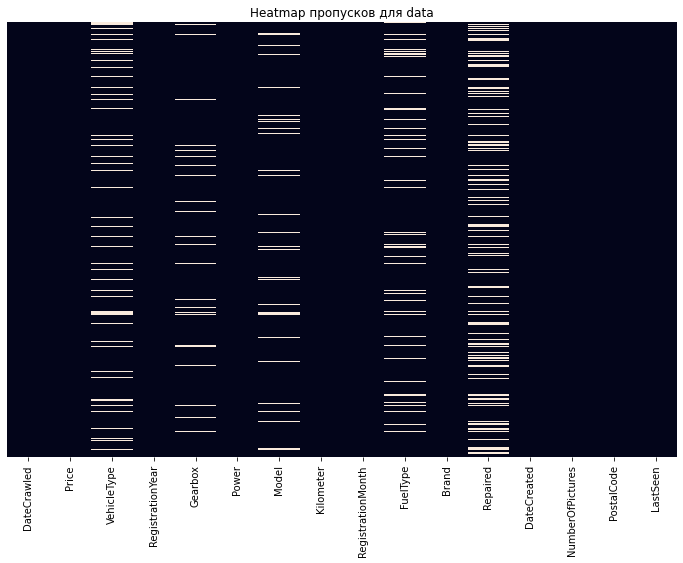

In [11]:
analyze_missing_values(data, 'data')

Избавимся от явных дубликатов, возможно, после обработки датасета и удаления ненужных переменных дубликатов станет больше.

In [ ]:
data = data.drop(['date_crawled', 'registration_month', 'date_created', 
                  'number_of_pictures', 'postal_code', 'last_seen']

In [13]:
display(data[['Repaired','VehicleType', 'FuelType', 'Gearbox', 'Model']].sample(10))

,Repaired,VehicleType,FuelType,Gearbox,Model
220154,NaN,bus,gasoline,auto,voyager
340191,no,small,petrol,auto,fortwo
118771,no,sedan,petrol,manual,other
338130,no,sedan,petrol,manual,focus
25100,no,wagon,petrol,manual,2_reihe
175610,no,sedan,petrol,manual,golf
43266,NaN,NaN,petrol,manual,NaN
323563,no,sedan,petrol,manual,astra
81005,no,wagon,gasoline,auto,3er
110889,no,sedan,petrol,manual,3er


## Обучение моделей

## Анализ моделей

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Выполнена загрузка и подготовка данных
- [ ]  Выполнено обучение моделей
- [ ]  Есть анализ скорости работы и качества моделей